In [1]:
!pip install datasets


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
from datasets import load_dataset
dataset = load_dataset("multi_woz_v22")

In [7]:
from datasets import DatasetDict
dataset = DatasetDict.load_from_disk("dataset.hf")

FileNotFoundError: No such file: 'dataset.hf\dataset_dict.json'. Expected to load a `DatasetDict` object, but provided path is not a `DatasetDict`.

In [8]:
import pandas as pd

data=[]
train_data = dataset['train']

for i in range(len(train_data)):
    data.append(train_data[i])

In [14]:
data=[]
train_data = dataset['train']

for i in range(len(train_data)):
  data.append(train_data[i])

sentences = []
slot_labels = []
intent=[]

for i in range(len(data)):
    for j in range(len(data[i]['turns']['speaker'])):

        turn = data[i]['turns']['speaker'][j]

        if int(turn) == 0 and data[i]['turns']['frames'][j]['state'] != []:
            slots_values_list = data[i]['turns']['frames'][j]['state'][0]['slots_values']['slots_values_list']
            slots_values_names = data[i]['turns']['frames'][j]['state'][0]['slots_values']['slots_values_name']
            intent.append(data[i]['turns']['frames'][j]['state'][0]['active_intent'])
            sentences.append(data[i]['turns']['utterance'][j])
            words = data[i]['turns']['utterance'][j].split()
            words = [word.rstrip('.') for word in words]


            label = []
            word_count = {}

            for word in words:
                found = False
                if word not in word_count:
                    word_count[word] = 1
                else:
                    word_count[word] += 1

                for idx, slot_values in enumerate(slots_values_list):
                    if word in slot_values:
                        if word_count[word] > 1 and (idx + word_count[word] - 1) < len(slots_values_names):
                            label.append(slots_values_names[idx + word_count[word] - 1])
                        else:
                            label.append(slots_values_names[idx])
                        found = True
                        break
                if not found:
                    label.append(0)
            converted_list = ['O' if item == 0 else str(item) for item in label]
            result = ' '.join(converted_list)
            slot_labels.append(converted_list)

In [15]:
lens=[]
for i in range(len(sentences)):
  lens.append(len(sentences[i]))

df_validation = pd.DataFrame({'intent_label': intent[0:4789],'words': sentences[0:4789], 'words_label': slot_labels[0:4789], 'length': lens[0:4789]})
df_test = pd.DataFrame({'intent_label': intent[4790:9579],'words': sentences[4790:9579], 'words_label': slot_labels[4790:9579], 'length': lens[4790:9579]})
df_train = pd.DataFrame({'intent_label': intent[9580:47896],'words': sentences[9580:47896], 'words_label': slot_labels[9580:47896], 'length': lens[9580:47896]})
print(df_train)


          intent_label                                              words  \
0      find_restaurant              I would like an expensive restaurant.   
1      book_restaurant         For 7 people at 11:15 on Saturday, please.   
2      book_restaurant  Caffe Uno will be fine. Yes, I'll need to rese...   
3            find_taxi  Great I also need to get a taxi that can get m...   
4      book_restaurant  Can I have a reference number for the restaurant?   
...                ...                                                ...   
38311  find_restaurant                            Is there anything else?   
38312  find_restaurant                        what is there phone number?   
38313  find_restaurant  Hello, I am looking for a cheap restaurant tha...   
38314  find_restaurant                    Yes, how about portuguese food?   
38315  find_restaurant                                 It doesn't matter.   

                                             words_label  length  
0       

In [16]:
# Count the number of lines by intent label
df_train.intent_label.value_counts()

intent_label
find_restaurant    7704
find_hotel         7413
find_train         6654
find_attraction    5344
book_restaurant    3229
book_hotel         3020
find_taxi          2392
book_train         1676
find_hospital       504
find_police         376
find_bus              4
Name: count, dtype: int64


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


array([[<Axes: title={'center': 'length'}>]], dtype=object)

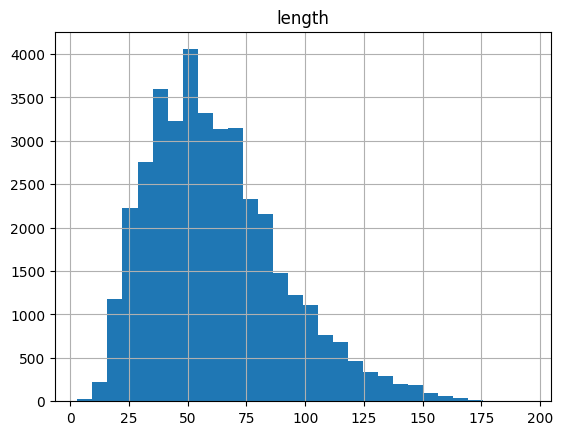

In [17]:
!pip install matplotlib
# Histogram of sentence lengths
df_train.hist('length', bins=30)

## Intent classification (sentence level)¶
Let's ignore the slot filling task for now and let's try to build a sentence level classifier by fine-tuning a pre-trained Transformer-based model using the huggingface/transformers package that provides both Tensorflow/Keras and Pytorch APIs.

**The BERT tokenizer**
First let's load a pre-trained tokenizer and test it on a test sentence from the training set.

In [18]:
!pip install transformers
from transformers import BertTokenizer, TFBertModel
model_name = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)



[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
first_sentence = df_train.iloc[0]['words']
print(first_sentence)

I would like an expensive restaurant.


In [22]:
tokenizer.tokenize(first_sentence)

['I', 'would', 'like', 'an', 'expensive', 'restaurant', '.']

In [23]:
# Encode sentence to id
tokenizer.encode(first_sentence)

[101, 146, 1156, 1176, 1126, 5865, 4382, 119, 102]

In [24]:
# Do the inverse operation
tokenizer.decode(tokenizer.encode(first_sentence))

'[CLS] I would like an expensive restaurant. [SEP]'

Remarks:

* The first token [CLS] is used by the pre-training task for sequence classification.
* The last token [SEP] is a separator for the pre-training task that classifies if a pair of sentences are consecutive in a corpus or not (next sentence prediction).
* Here, we want to use BERT to compute a representation of a single voice command at a time.
* We could reuse the representation of the [CLS] token for sequence classification.
* Alternatively, we can pool the representations of all the tokens of the voice command (e.g. global average) and use that as the input of the final sequence classification layer.

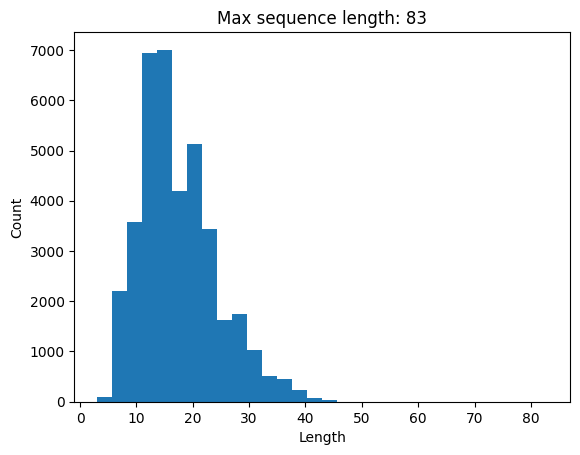

In [25]:
import matplotlib.pyplot as plt
train_sequence_lengths = [len(tokenizer.encode(text))
                          for text in df_train['words']]
plt.hist(train_sequence_lengths, bins=30)
plt.title(f'Max sequence length: {max(train_sequence_lengths)}')
plt.xlabel('Length')
plt.ylabel('Count')
plt.show()

To perform transfer learning, we will need to work with padded sequences. So, they all have the same sizes. The above histograms, shows that after tokenization,  $50$  tokens are enough to represent all the voice commands in the training set.

The mapping can be introspected in the tokenizer.vocab attribute.

In [26]:
print(f'Vocabulary size: {tokenizer.vocab_size} words.')

Vocabulary size: 28996 words.


In [27]:
# Get the items in BERT
bert_vocab_items = list(tokenizer.vocab.items())
# Print some examples of items
bert_vocab_items[250:260]

[('ä', 250),
 ('å', 251),
 ('æ', 252),
 ('ç', 253),
 ('è', 254),
 ('é', 255),
 ('ê', 256),
 ('ë', 257),
 ('ì', 258),
 ('í', 259)]

## Encoding the dataset with the tokenizer
Let's now encode the full train/validation and test sets with our tokenizer to get a padded integer numpy arrays.

In [28]:
def encode_dataset(tokenizer, text_sequences, max_length):
    token_ids = np.zeros(shape=(len(text_sequences), max_length),
                         dtype=np.int32)
    for i, text_sequence in enumerate(text_sequences):
        encoded = tokenizer.encode(text_sequence)
        token_ids[i, 0:len(encoded)] = encoded
    attention_masks = (token_ids != 0).astype(np.int32)

    return {'input_ids': token_ids, 'attention_masks': attention_masks}

In [29]:
import numpy as np

encoded_train = encode_dataset(tokenizer, df_train['words'], 90)
encoded_validation = encode_dataset(tokenizer, df_validation['words'], 90)
encoded_test = encode_dataset(tokenizer, df_test['words'], 90)

## Encoding the sequence classification targets
To do so, we build a simple mapping from the auxiliary files.

In [32]:
intent_names = set(intent)
intent_map = dict((label, idx) for idx, label in enumerate(intent_names))
intent_map

{'book_hotel': 0,
 'find_restaurant': 1,
 'find_bus': 2,
 'book_restaurant': 3,
 'find_hospital': 4,
 'find_taxi': 5,
 'find_police': 6,
 'book_train': 7,
 'find_attraction': 8,
 'find_train': 9,
 'find_hotel': 10}

In [33]:
intent_train = df_train['intent_label'].map(intent_map).values
intent_validation = df_validation['intent_label'].map(intent_map).values
intent_test = df_test['intent_label'].map(intent_map).values

## Loading and feeding a pretrained BERT model
Let's load a pretrained BERT model using the huggingface transformers package.

In [34]:
!pip install TensorFlow
import transformers

base_bert_model = TFBertModel.from_pretrained(model_name)
base_bert_model.summary()


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
c:\Users\neusv\OneDrive\Documentos\EMAI UPF\NATURAL LENGUAGE INTERACTION\Project ChatBot\NLP-Chat-Bot-project\env\Lib\site-packages\huggingface_hub\file_download.py:137: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\neusv\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-star

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108310272 (413.17 MB)
Trainable params: 108310272 (413.17 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
outputs = base_bert_model(encoded_validation)
print(f'Shape of the first output of the BERT model: {outputs[0].shape}.')
print(f'Shape of the second output of the BERT model: {outputs[1].shape}.')

In [37]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam

# Define IntentClassification model
class IntentClassificationModel(tf.keras.Model):
    def __init__(self, intent_num_labels=None,
                 model_name='bert-base-cased',
                 dropout_prob=0.1):
        super().__init__(name='joint_intent_slot')
        # Let's preload the pretrained model BERT in the constructor
        # of our classifier model.
        self.bert = TFBertModel.from_pretrained(model_name)
        self.dropout = Dropout(dropout_prob)

        # Define a (Dense) classification layer to compute for each
        # sequence in a batch of samples. The number of output classes
        # is given by the intent_num_labels parameter.
        # Use the default linear activation (no softmax) to compute
        # logits. The softmax normalization will be computed in the
        # loss function instead of the model itself.
        self.intent_classifier = Dense(intent_num_labels)

    def call(self, inputs, **kwargs):
        # Use the pretrained model to extract features from our
        # encoded inputs.
        sequence_output, pooled_output = self.bert(inputs, **kwargs)

        # The second output of the main BERT layer has shape:
        # (batch_size, output_dim) and gives a "pooled" representation
        # for the full sequence from the hidden state that corresponds
        # to the "[CLS]" token.
        pooled_output = self.dropout(pooled_output, training=kwargs.get('training', False))

        # Use the classifier layer to compute the logits from the
        # pooled features.
        intent_logits = self.intent_classifier(pooled_output)
        return intent_logits

In [38]:
# Build the model
intent_model = IntentClassificationModel(intent_num_labels=len(intent_map))

intent_model.compile(optimizer=Adam(learning_rate=3e-5, epsilon=1e-08),
                     loss=SparseCategoricalCrossentropy(from_logits=True),
                     metrics=[SparseCategoricalAccuracy('accuracy')])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [43]:
# Train the model
#Probably we need to add ['inputs_id'] to the data
history = intent_model.fit(encoded_train, intent_train,
                           epochs=2, batch_size=32,
                           validation_data=(encoded_validation, intent_validation))

Epoch 1/2


TypeError: in user code:

    File "c:\Users\neusv\OneDrive\Documentos\EMAI UPF\NATURAL LENGUAGE INTERACTION\Project ChatBot\NLP-Chat-Bot-project\env\Lib\site-packages\keras\src\engine\training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\neusv\OneDrive\Documentos\EMAI UPF\NATURAL LENGUAGE INTERACTION\Project ChatBot\NLP-Chat-Bot-project\env\Lib\site-packages\keras\src\engine\training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\neusv\OneDrive\Documentos\EMAI UPF\NATURAL LENGUAGE INTERACTION\Project ChatBot\NLP-Chat-Bot-project\env\Lib\site-packages\keras\src\engine\training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\neusv\OneDrive\Documentos\EMAI UPF\NATURAL LENGUAGE INTERACTION\Project ChatBot\NLP-Chat-Bot-project\env\Lib\site-packages\keras\src\engine\training.py", line 1126, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\neusv\OneDrive\Documentos\EMAI UPF\NATURAL LENGUAGE INTERACTION\Project ChatBot\NLP-Chat-Bot-project\env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\neusv\AppData\Local\Temp\__autograph_generated_filea3znfh4h.py", line 10, in tf__call
        sequence_output, pooled_output = ag__.converted_call(ag__.ld(self).bert, (ag__.ld(inputs),), dict(**ag__.ld(kwargs)), fscope)
    File "C:\Users\neusv\AppData\Local\Temp\__autograph_generated_filer7l1kwla.py", line 40, in tf__run_call_with_unpacked_inputs
        raise

    TypeError: Exception encountered when calling layer 'joint_intent_slot' (type IntentClassificationModel).
    
    in user code:
    
        File "C:\Users\neusv\AppData\Local\Temp\ipykernel_60960\298034465.py", line 29, in call  *
            sequence_output, pooled_output = self.bert(inputs, **kwargs)
        File "c:\Users\neusv\OneDrive\Documentos\EMAI UPF\NATURAL LENGUAGE INTERACTION\Project ChatBot\NLP-Chat-Bot-project\env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "C:\Users\neusv\AppData\Local\Temp\__autograph_generated_filer7l1kwla.py", line 40, in tf__run_call_with_unpacked_inputs
            raise
    
        TypeError: Exception encountered when calling layer 'tf_bert_model_1' (type TFBertModel).
        
        in user code:
        
            File "c:\Users\neusv\OneDrive\Documentos\EMAI UPF\NATURAL LENGUAGE INTERACTION\Project ChatBot\NLP-Chat-Bot-project\env\Lib\site-packages\transformers\modeling_tf_utils.py", line 1061, in run_call_with_unpacked_inputs  *
                return func(self, **unpacked_inputs)
        
            TypeError: outer_factory.<locals>.inner_factory.<locals>.tf__call() got an unexpected keyword argument 'attention_masks'
        
        
        Call arguments received by layer 'tf_bert_model_1' (type TFBertModel):
          • input_ids={'input_ids': 'tf.Tensor(shape=(None, 90), dtype=int32)', 'attention_masks': 'tf.Tensor(shape=(None, 90), dtype=int32)'}
          • attention_mask=None
          • token_type_ids=None
          • position_ids=None
          • head_mask=None
          • inputs_embeds=None
          • encoder_hidden_states=None
          • encoder_attention_mask=None
          • past_key_values=None
          • use_cache=None
          • output_attentions=None
          • output_hidden_states=None
          • return_dict=None
          • training=True
    
    
    Call arguments received by layer 'joint_intent_slot' (type IntentClassificationModel):
      • inputs={'input_ids': 'tf.Tensor(shape=(None, 90), dtype=int32)', 'attention_masks': 'tf.Tensor(shape=(None, 90), dtype=int32)'}
      • kwargs={'training': 'True'}


In [46]:
def classify(text, tokenizerzer, model, intent_names):
    inputs = tf.constant(tokenizer.encode(text))[None, :] # Batch size = 1
    class_id = model(inputs).numpy().argmax(axis=1)[0]
    return intent_names[class_id]

In [47]:
# Example of classification
classify('Can I book a table for 2?',
         tokenizer, intent_model, intent_names)

ValueError: Exception encountered when calling layer 'joint_intent_slot' (type IntentClassificationModel).

Input 0 of layer "dense" is incompatible with the layer: expected min_ndim=2, found ndim=0. Full shape received: ()

Call arguments received by layer 'joint_intent_slot' (type IntentClassificationModel):
  • inputs=tf.Tensor(shape=(1, 9), dtype=int32)
  • kwargs={'training': 'None'}

In [51]:
!pip install pathlib
from pathlib import Path
from transformers import BertTokenizer, TFBertModel
from urllib.request import urlretrieve



[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [67]:
df_train['words_label'][i]

['O', 'O', 'O', 'O', 'restaurant-pricerange', 'O']

## Join intent classification and slot filling
Let's now refine our natural language understanding system by trying to retrieve the important structured elements of each voice command. To do so, we will perform word level (or token level) classification of the BIO labels. Since we have word level tags but BERT uses a wordpiece tokenizer, we need to align the BIO labels with the BERT tokens. Let's load the list of possible word token labels and augment it with an additional padding label to be able to ignore special tokens.

In [80]:
#data
slot_names = []

for i in range(len(df_train)):
    for j in range(len(df_train['words_label'][i])):
        item = df_train['words_label'][i][j]
        if  item != 'O' and item not in slot_names:
            slot_names.append(item)

slot_map = dict({slot: index for index, slot in enumerate(slot_names)})
slot_map

{'restaurant-pricerange': 0,
 'restaurant-bookpeople': 1,
 'restaurant-booktime': 2,
 'taxi-arriveby': 3,
 'train-day': 4,
 'train-arriveby': 5,
 'restaurant-food': 6,
 'train-destination': 7,
 'train-bookpeople': 8,
 'taxi-destination': 9,
 'hotel-pricerange': 10,
 'hotel-area': 11,
 'restaurant-area': 12,
 'attraction-type': 13,
 'restaurant-bookday': 14,
 'hotel-type': 15,
 'hotel-stars': 16,
 'attraction-area': 17,
 'taxi-leaveat': 18,
 'hotel-bookpeople': 19,
 'hotel-bookstay': 20,
 'hotel-bookday': 21,
 'train-departure': 22,
 'train-leaveat': 23,
 'restaurant-name': 24,
 'hotel-name': 25,
 'hospital-department': 26,
 'taxi-departure': 27,
 'hotel-internet': 28,
 'hotel-parking': 29,
 'attraction-name': 30,
 'bus-destination': 31}

In [74]:
def encode_token_labels(text_sequences, slot_names, tokenizer, slot_map, max_length):
    encoded = np.zeros(shape=(len(text_sequences), max_length), dtype=np.int32)
    for i, (text_sequence, word_labels) in enumerate(
            zip(text_sequences, slot_names)):
        encoded_labels = []
        for word, word_label in zip(text_sequence.split(), word_labels.split()):
            tokens = tokenizer.tokenize(word)
            encoded_labels.append(slot_map[word_label])
            expand_label = word_label.replace("B-", "I-")
            if not expand_label in slot_map:
                expand_label = word_label
            encoded_labels.extend([slot_map[expand_label]] * (len(tokens) - 1))
        encoded[i, 1:len(encoded_labels) + 1] = encoded_labels
    return encoded

In [81]:
slot_train = encode_token_labels(df_train['words'], df_train['words_label'], tokenizer, slot_map, 45)
slot_validation = encode_token_labels(df_validation['words'], df_validation['words_label'], tokenizer, slot_map, 45)
slot_test = encode_token_labels(df_test['words'], df_test['words_label'], tokenizer, slot_map, 45)

AttributeError: 'list' object has no attribute 'split'

In [84]:
# Define JointIntentAndSlotFilling model
class JointIntentAndSlotFillingModel(tf.keras.Model):

    def __init__(self, intent_num_labels=None, slot_num_labels=None,
                 model_name="bert-base-cased", dropout_prob=0.1):
        super().__init__(name="joint_intent_slot")
        self.bert = TFBertModel.from_pretrained(model_name)
        self.dropout = Dropout(dropout_prob)
        self.intent_classifier = Dense(intent_num_labels,
                                       name="intent_classifier")
        self.slot_classifier = Dense(slot_num_labels,
                                     name="slot_classifier")

    def call(self, inputs, **kwargs):
        sequence_output, pooled_output = self.bert(inputs, **kwargs)

        # The first output of the main BERT layer has shape:
        # (batch_size, max_length, output_dim)
        sequence_output = self.dropout(sequence_output,
                                       training=kwargs.get("training", False))
        slot_logits = self.slot_classifier(sequence_output)

        # The second output of the main BERT layer has shape:
        # (batch_size, output_dim)
        # and gives a "pooled" representation for the full sequence from the
        # hidden state that corresponds to the "[CLS]" token.
        pooled_output = self.dropout(pooled_output,
                                     training=kwargs.get("training", False))
        intent_logits = self.intent_classifier(pooled_output)

        return slot_logits, intent_logits


NameError: name 'slot_train' is not defined

In [ ]:
joint_model = JointIntentAndSlotFillingModel(
    intent_num_labels=len(intent_map), slot_num_labels=len(slot_map))

# Define one classification loss for each output:
opt = Adam(learning_rate=3e-5, epsilon=1e-08)
losses = [SparseCategoricalCrossentropy(from_logits=True),
          SparseCategoricalCrossentropy(from_logits=True)]
metrics = [SparseCategoricalAccuracy('accuracy')]
joint_model.compile(optimizer=opt, loss=losses, metrics=metrics)

In [ ]:
history = joint_model.fit(
    encoded_train, (slot_train, intent_train),
    validation_data=(encoded_validation, (slot_validation, intent_validation)),
    epochs=2, batch_size=32)

In [ ]:
def show_predictions(text, tokenizer, model, intent_names, slot_names):
    inputs = tf.constant(tokenizer.encode(text))[None, :]  # batch_size = 1
    outputs = model(inputs)
    slot_logits, intent_logits = outputs
    slot_ids = slot_logits.numpy().argmax(axis=-1)[0, 1:-1]
    intent_id = intent_logits.numpy().argmax(axis=-1)[0]
    print("## Intent:", intent_names[intent_id])
    print("## Slots:")
    for token, slot_id in zip(tokenizer.tokenize(text), slot_ids):
        print(f"{token:>10} : {slot_names[slot_id]}")

## EXAMPLE OF PREDICTION

In [ ]:
show_predictions('Will it snow tomorrow in Paris?',
                 tokenizer, joint_model, intent_names, slot_names)

## Decoding predictions into structured knowledge
For completeness, here a minimal functional to naively decode the predicted BIO slot ids and convert it into a structured representation for the detected slots as a Python dictionaries.

In [ ]:
def decode_predictions(text, tokenizer, intent_names, slot_names,
                       intent_id, slot_ids):
    info = {"intent": intent_names[intent_id]}
    collected_slots = {}
    active_slot_words = []
    active_slot_name = None
    for word in text.split():
        tokens = tokenizer.tokenize(word)
        current_word_slot_ids = slot_ids[:len(tokens)]
        slot_ids = slot_ids[len(tokens):]
        current_word_slot_name = slot_names[current_word_slot_ids[0]]
        if current_word_slot_name == "O":
            if active_slot_name:
                collected_slots[active_slot_name] = " ".join(active_slot_words)
                active_slot_words = []
                active_slot_name = None
        else:
            # Naive BIO: handling: treat B- and I- the same...
            new_slot_name = current_word_slot_name[2:]
            if active_slot_name is None:
                active_slot_words.append(word)
                active_slot_name = new_slot_name
            elif new_slot_name == active_slot_name:
                active_slot_words.append(word)
            else:
                collected_slots[active_slot_name] = " ".join(active_slot_words)
                active_slot_words = [word]
                active_slot_name = new_slot_name
    if active_slot_name:
        collected_slots[active_slot_name] = " ".join(active_slot_words)
    info["slots"] = collected_slots
    return info

In [ ]:
def nlu(text, tokenizer, model, intent_names, slot_names):
    inputs = tf.constant(tokenizer.encode(text))[None, :]  # batch_size = 1
    outputs = model(inputs)
    slot_logits, intent_logits = outputs
    slot_ids = slot_logits.numpy().argmax(axis=-1)[0, 1:-1]
    intent_id = intent_logits.numpy().argmax(axis=-1)[0]

    return decode_predictions(text, tokenizer, intent_names, slot_names,
                              intent_id, slot_ids)

In [ ]:
nlu('Will it snow tomorrow in Paris?',
                 tokenizer, joint_model, intent_names, slot_names)

In [ ]:
nlu('I would like to listen to Wake me up by Avicii.',
    tokenizer, joint_model, intent_names, slot_names)